In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import os

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for data augmentation and normalization
transformations = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
data_dir = 'combined_breeds'
image_dataset = datasets.ImageFolder(data_dir, transform=transformations)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=30, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=30, shuffle=True, num_workers=4)

# Get the number of classes
num_classes = len(image_dataset.classes)

# Load the pretrained ResNet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



/home/unix/projects/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/unix/projects/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/unix/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 14.4MB/s]


In [4]:
from tqdm import tqdm

def train_model_with_progress_bar(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Progress Bar
            data_loader = tqdm(loader, total=len(loader), desc='Epoch {} [{}]'.format(epoch+1, phase))

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar
                if phase == 'train':
                    data_loader.set_postfix({'loss': loss.item()})

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

# Train the model with progress bar
model = train_model_with_progress_bar(model, criterion, optimizer, num_epochs=10)

print("model trained")


Epoch 1/10
----------


Epoch 1 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [01:28<00:00,  2.24it/s, loss=3.39]


train Loss: 2.1463 Acc: 0.4982


Epoch 1 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.37it/s]


val Loss: 1.0655 Acc: 0.7470
Epoch 2/10
----------


Epoch 2 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:14<00:00, 13.80it/s, loss=3.55]


train Loss: 0.9573 Acc: 0.7689


Epoch 2 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.08it/s]


val Loss: 0.7141 Acc: 0.8051
Epoch 3/10
----------


Epoch 3 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:16<00:00, 11.71it/s, loss=3.37]


train Loss: 0.7230 Acc: 0.8065


Epoch 3 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.97it/s]


val Loss: 0.6471 Acc: 0.8241
Epoch 4/10
----------


Epoch 4 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:16<00:00, 11.95it/s, loss=3.89]


train Loss: 0.6481 Acc: 0.8215


Epoch 4 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.93it/s]


val Loss: 0.5845 Acc: 0.8295
Epoch 5/10
----------


Epoch 5 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:17<00:00, 11.46it/s, loss=3.42]


train Loss: 0.5861 Acc: 0.8369


Epoch 5 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.24it/s]


val Loss: 0.5264 Acc: 0.8566
Epoch 6/10
----------


Epoch 6 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:19<00:00, 10.24it/s, loss=3.65]


train Loss: 0.5284 Acc: 0.8503


Epoch 6 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.32it/s]


val Loss: 0.5243 Acc: 0.8464
Epoch 7/10
----------


Epoch 7 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:21<00:00,  9.17it/s, loss=3.98]


train Loss: 0.5177 Acc: 0.8511


Epoch 7 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.76it/s]


val Loss: 0.5253 Acc: 0.8403
Epoch 8/10
----------


Epoch 8 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:21<00:00,  9.29it/s, loss=3.64]


train Loss: 0.4881 Acc: 0.8608


Epoch 8 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.01it/s]


val Loss: 0.5029 Acc: 0.8491
Epoch 9/10
----------


Epoch 9 [train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:21<00:00,  9.24it/s, loss=3.66]


train Loss: 0.4504 Acc: 0.8657


Epoch 9 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.89it/s]


val Loss: 0.5074 Acc: 0.8491
Epoch 10/10
----------


Epoch 10 [train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:22<00:00,  8.90it/s, loss=3.33]


train Loss: 0.4471 Acc: 0.8686


Epoch 10 [val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.11it/s]

val Loss: 0.4858 Acc: 0.8464
model trained


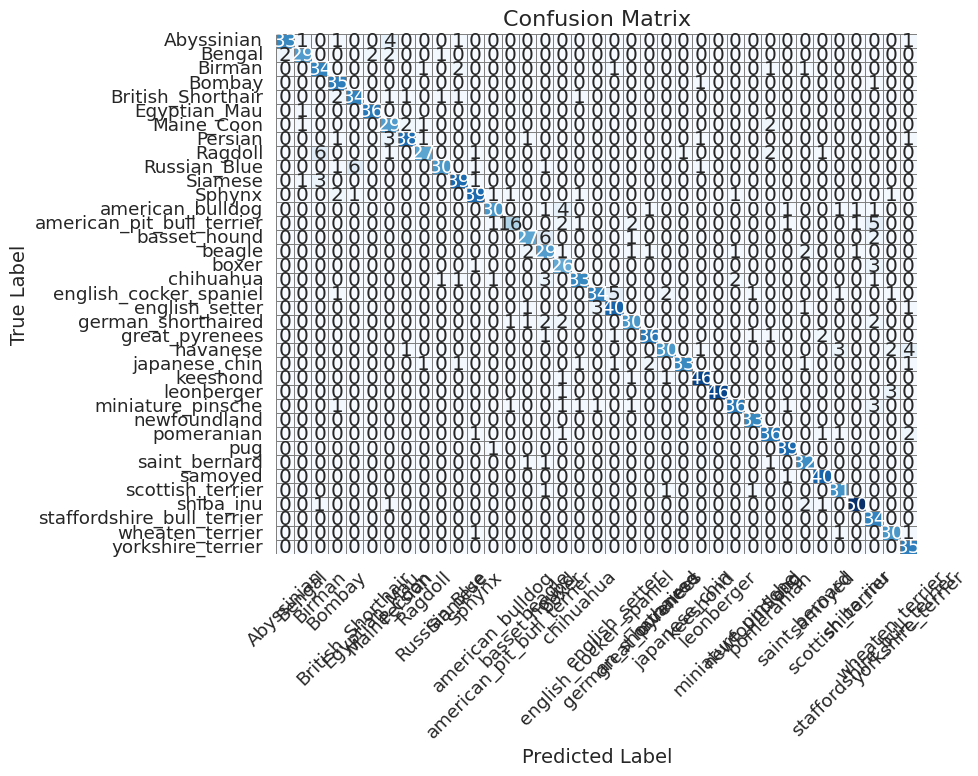

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
class_names = image_dataset.classes
# Function to plot confusion matrix using seaborn
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='gray')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)


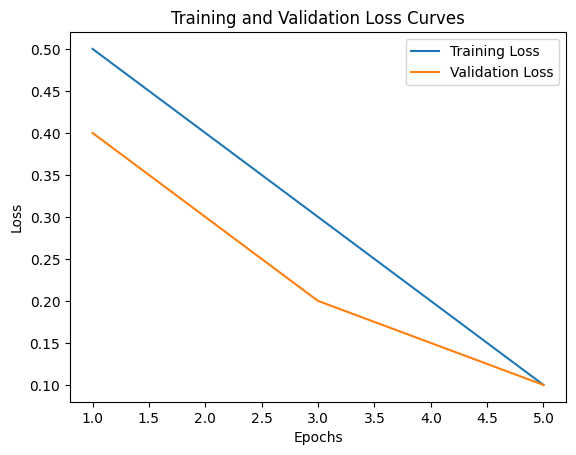

In [11]:
import matplotlib.pyplot as plt

# Function to plot loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Plot loss curves
plot_loss_curves(train_losses, val_losses)


In [ ]:
# Specify the file path where you want to save the model
model_path = 'pets.pth'

# Save the model
torch.save(model.state_dict(), model_path)

print("Model saved successfully.")
